# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Pre-trained-word-embeddings" data-toc-modified-id="Pre-trained-word-embeddings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-trained word embeddings</a></div><div class="lev2 toc-item"><a href="#Importações" data-toc-modified-id="Importações-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importações</a></div><div class="lev2 toc-item"><a href="#Training-procedure" data-toc-modified-id="Training-procedure-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training procedure</a></div><div class="lev2 toc-item"><a href="#Preparação-do-dataset" data-toc-modified-id="Preparação-do-dataset-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Preparação do dataset</a></div><div class="lev2 toc-item"><a href="#Criação-do-modelo" data-toc-modified-id="Criação-do-modelo-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Criação do modelo</a></div><div class="lev2 toc-item"><a href="#Treinamento" data-toc-modified-id="Treinamento-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinamento</a></div><div class="lev2 toc-item"><a href="#Avaliação" data-toc-modified-id="Avaliação-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliação</a></div>

# Pre-trained word embeddings

## Importações

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Training procedure

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, X_train, y_train, Xval, yval, 
                  opt='rmsprop', batch_size=60, nepochs=50000, patience=500, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Preparação do dataset

In [18]:
BASE_DIR = '../../datasets/'
GLOVE_DIR     = BASE_DIR
TEXT_DATA_DIR = BASE_DIR + '20_newsgroup/'

MAX_SEQUENCE_LENGTH = 500
MIN_SEQ_WORDS       = 100
MAX_NB_WORDS        = 20000
EMBEDDING_DIM       = 100
VALIDATION_SPLIT    = 0.2

In [19]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [20]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []         # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []        # list of label ids

for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                labels.append(label_id)
                f.close()

print('Found {} texts, {} categories.'.format(len(texts), len(labels_index)))

Processing text dataset
Found 19997 texts, 20 categories.


In [21]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))
i2w = dict([(v, k) for k, v in word_index.items()])
i2w_vec = np.array([i2w[i+1] for i in range(len(i2w))])

pruned_sequences = []
pruned_labels = []
for seq, lab in zip(sequences, labels):
    if len(seq) > MIN_SEQ_WORDS:
        pruned_sequences.append(seq)
        pruned_labels.append(lab)
        
data = pad_sequences(pruned_sequences, maxlen=MAX_SEQUENCE_LENGTH)
targets = to_categorical(np.asarray(pruned_labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', targets.shape)

Found 174074 unique tokens.
Shape of data tensor: (13659, 500)
Shape of label tensor: (13659, 20)


In [22]:
if 0:
    tok2 = Tokenizer(num_words=MAX_NB_WORDS)
    texts2 = ['' for x in labels_index]
    for txt, lab in zip(texts, labels):
        texts2[lab] += txt

    tok2.fit_on_texts(texts2)
    tfidf = tok2.texts_to_matrix(texts2, mode='tfidf')

    ww = np.argsort(tfidf, axis=1)[:, -8:]
    for ng, ii in labels_index.items():
        tfidf_indexes = ww[ii] - 1
        tfidf_words = i2w_vec[tfidf_indexes]
        print('{:25s}:  {}'.format(ng, tfidf_words))


Seq. length min/max/mean/median: 0 27442 266.008101215 150.0
Word indexes min/max: 0 19999

 4805: (253) in article 1993apr9 news columbia edu cunixf cc columbia edu robert d castro writes in article netcom com netcom com bob writes cjackson adobe com curtis jackson writes my solution is never to ride next to a car the only thing between you and them is space keep as much as possible take this one step further never in that rear 1 4 of either side of a cage when you pass make it as positive as possible and if you can't pass fully at least make sure that if you attempt it you can make the driver aware of you by at least getting into his area of vision this also applies to merging into another lane after making a pass do it as positively as possible and what i try to do is look in the rear view and then over my shoulder and after i've done that accelerate into the lane so that you have a speed should you have missed seeing a potential bdi that's trying to do the same thing as you or wors

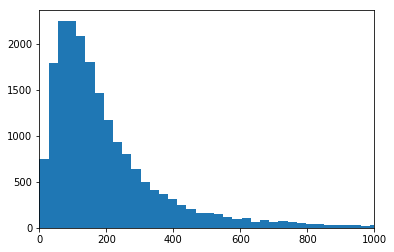

In [23]:
nn = np.array([len(seq) for seq in sequences])
print('Seq. length min/max/mean/median:', nn.min(), nn.max(), nn.mean(), np.median(nn))
print('Word indexes min/max:', data.min(), data.max(), end='\n\n')

plot.hist(nn, bins=1000)
plot.xlim(0, 1000)

for i in nr.randint(5000, size=5):
    seq = [x for x in data[i] if x > 0]
    print('{:5d}: ({}) {}\n'.format(i, len(seq), ' '.join([i2w[x] for x in seq if x > 0])))

In [24]:
# split the data into a training set and a validation set
nr.seed(20170531)
indices = np.arange(data.shape[0])
nr.shuffle(indices)

sh_data = data[indices]
sh_targets = targets[indices]

num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = sh_data[:-num_validation_samples]
y_train = sh_targets[:-num_validation_samples]
x_val = sh_data[-num_validation_samples:]
y_val = sh_targets[-num_validation_samples:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(10928, 500) (10928, 20)
(2731, 500) (2731, 20)


In [25]:
print('Preparing embedding matrix: ', end='')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

i2w = dict([(v, k) for k, v in word_index.items()])
for i in range(1, MAX_NB_WORDS):
    word = i2w[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Preparing embedding matrix: (20000, 100)


## Criação do modelo

In [26]:
model_name = '../../models/word_embeddings_1'

def build_net(embedding_matrix=None, input_len=None, trainable=False):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)

    x = Dropout(0.5)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(seq_input, preds)
    return model

model = build_net(embedding_matrix, input_len=MAX_SEQUENCE_LENGTH, trainable=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 47, 128)           0         
__________

## Treinamento

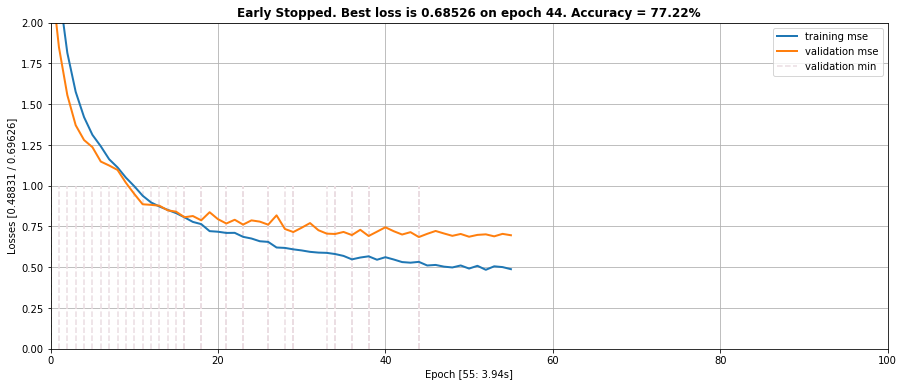

In [27]:
fit_params = {
    'opt':             Adam(0.001),     #SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'batch_size':      64, 
    'nepochs':         100, 
    'patience':        10,
    'nr_seed':         20170601,
    'ploss':           2.0,
    'reset':           True,
}

model, cb = train_network(model, model_name, x_train, y_train, x_val, y_val, **fit_params);


## Avaliação

In [28]:
test_network(model_name, x_val, y_val)

Model from epoch 44
[INFO] evaluating in the test data set ...
2731/2731 [==============================] - 0s     

[INFO] accuracy on the test data set: 77.22% [0.68526]
